# Digital Quantum Simulations
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

In this tutorial, we will introduce time evolution of quantum states and how to simulate them using the Trotter-Suzuki formalism.  We then show to how to run the time evolution of a one dimensional Ising chain with three sites.

## Contents
1. [Introduction](#introduction)
2. [Trotter-Suzuki Formalism](#ts-equation)
3. [The Heisenberg Model](#heisenberg-equation)
4. [Trotterization](#trotterization)
5. [Qiskit Implementation](#qiskit)

## Introduction <a id='introduction'></a>

Classical simulation of physical systems typically begin by solving simple differential equations such as $\frac{dy}{dt} = f(y)$ which, to first order, has the solution $y(t+\Delta t)\approx y(t)+f(y)\Delta t$.  Meanwhile in quantum mechanics, we are concerned with the solution to $-i\hbar\frac{d\ket{\psi}}{dt}=H\ket{\psi}$, which for a time-indepent $H$, is
$$ \ket{\Psi(t)} = e^{-i\hbar Ht}\ket{\Psi(0)} $$

and the simulation of a quantum system requires the ability to perform the operation above.  

In most cases, this reduces to matrix exponentiation, but proves to be very difficult on classical computers due to the exponential growth of the size of the operator as the system size/Hilbert space increases.  A good attempt at a first order solution is $\ket{\psi(t+\Delta t)}\approx (I-i\hbar H\Delta t)\ket{\psi(t)}$, but this is generally not satisfactory.  However, if we can exponentiate the Hamiltonian, we only need a sufficiently small time step to simulate our system

$$ \ket{\psi(t+\Delta t)}= e^{-i\hbar H\Delta t}\ket{\psi(t)} $$

Efficient approximations to the solution of this equation are possible for Hamiltonians which carry local interactions between the system's consitutent subsystems.  These classes of Hamiltonians can be written in the form

$$ H = \sum_k^L H_k $$

where each $H_k$ acts locally on only a portion of the total system.  For example, the terms are often just two-body interactions (such as $X_iX_j$) and one-body Hamiltonians (such as $Z_i$).  For the physicists out there, both the Ising and Hubbard models (as we'll see later on) can be written in this way.  The advantage of writing the Hamiltonian in this way is that although the total time evolution operator $e^{iHt}$ may be difficult to compute, it is much easier to use $e^{iH_kt}$ as it acts on a much smaller subsytem and is straightforward to approximate using quantum circuits.

## Trotter-Suzuki Formalism <a id='ts-equation'></a>

Now armed with this idea of considering the Hamiltonian as a sum over a set of smaller subsystems, we can examine what our time evolution operator looks like.  It is important to note that because the subsystem terms $H_k$ do not generally commute with each other, we can anotssume the exponential of the full Hamiltonian is a product of each of the terms $H_k$ i.e.

$$e^{-i\hbar Ht}\neq \prod_k e^{-i\hbar H_kt}.$$

We can move past this by using the first order Trotter-Suzuki formula which asymptotically approximates the sum

$$
   e^{-iHt} = \lim_{n\rightarrow\infty} \left(\prod_l e^{-iH_lt/n} \right)^n.
$$

From now on we'll set $\hbar=1$ (sorry experimentalists!).  So although we cannot exponentiate this Hamiltonian exactly, we can approximate it arbitrarily well using slices of size $1/n$.  Errors aside, this is still advantageous since we are able to efficiently implement a "difficult" gate $U(t)=e^{-iHt}$ by breaking the original problem into smaller pieces $e^{-iH_lt/n}$ which require only a limited set of elementary gates.


It may also help to provide a bit of an intuitive picture of the ST decomposition.  In his original paper discussing universal quantum simulators, Lloyd (S. Lloyd, Science 273, 1073) gave this example on the Trotter-Suzuki formalism:

<blockquote> The method for performing the simulation is conceptually straightforward, if mathematically involved. The goal is to get the simulator from point A to point B along a particular route. But the simulator can only be driven in certain directions--the operations that can be applied experimentally are limited--so it is usually not possible to go from point A to point B directly. But by moving the simulator first a little bit in one direction, then a little bit in another, then a little bit in another, and so on, it is possible to move from A to B. A car can only be driven forward and backward--it cannot be driven sideways. But it is still possible to parallel park. The following construction demonstrates a quantum analog of a familiar classical fact: By going forward and backing up a sufficiently small distance a large enough number of times, it is possible to parallel park in a space only $\epsilon$ longer than the length of the care </blockquote>

## The Quantum Ising Model <a id='ising-equation'></a>

The Ising model with a transverse field has the form
$$
    H_{Ising} = J\sum_i(Z_iZ_{i+1} + gX_i)
$$
where $J$ is a dimensionless coupling constant and $g$ is a similarly dimensionless constant corresponding to the strength of a transverse magnetic field.

In this model, two of the observables that are interesting to consider are the energy $\langle H \rangle$ and magnetization $\langle \sigma_z \rangle$.  For isolated systems, the energy should be constant in time (at least in the limit of the uncertainty principle) and so we'll be mostly focused on the magnetization which is a bit more interesting here.

The time evolution operator $U(t)$ has the form

$$
    e^{-itH} = \exp\left(-it\left(J\sum_i(Z_iZ_{i+1} + gX_i)\right)\right)
$$



###  Exact Evolution for 3 Spins

To get started with some data we can compare our circuit results to.  It turns out Qiskit has a nice set of tools we can use to produce this called `opflow` (there is also a [tutorial](https://qiskit.org/documentation/tutorials/operators/01_operator_flow.html) on this module if you are so inclined).  The cells below will build the Hamiltonian and corresponding (exact) time evolution operator, then apply it onto an initial state $|101\rangle$ and measure its expectation value for several times.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

# Import Qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z


In [2]:
# Returns matrix representation of the non-periodic Ising model for 3 spin-1/2 particles in a line
def H_ising(J: float, g: float):
    #Interactions (I is the identity matrix; X and Z are Pauli matrices; ^ is a tensor product; * multiplies a scalar)
    ZZs = (Z^Z^I) + (I^Z^Z)
    Xs = (X^I^I) + (I^X^I) + (I^I^X)
    
    H = -J*(ZZs + (g*Xs))
    return H

# Returns matrix representation of U_ising(t) for a given time t and a set of system parameters
def U_ising(t, J, g):
    #Compute the Ising Hamiltonian as above
    H = H_ising(J, g)
    # Return the exponential of -i*t multiplied by the 3 spin Ising Hamiltonian
    return (t * H).exp_i()


U =  e^(-i*-1.0 * ZZI
- 1.0 * IZZ
- 1.0 * XII
- 1.0 * IXI
- 1.0 * IIX)


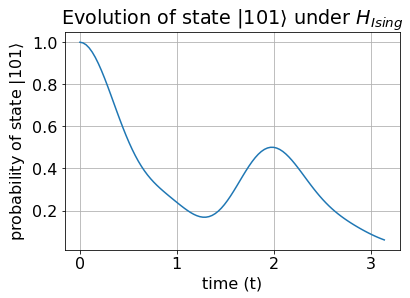

In [3]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)
J = 1.0
g = 1.

# Define initial state |101>
initial_state = One^Zero^One

#Test out U operator for time t=1.0
U = U_ising(1., J, g)
print("U = ",U)

# Compute probability of remaining in |101> state over the array of time points
 # The '~' gives the bra of the initial state (<101|)
 # @ is short hand for matrix multiplication
 # U_ising(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <101|U_ising(t)|101>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_101 = [np.abs((~initial_state @ U_ising(float(t), J, g) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |101>
plt.plot(ts, probs_101)
plt.xlabel('time (t)')
plt.ylabel(r'probability of state $|101\rangle$')
plt.title(r'Evolution of state $|101\rangle$ under $H_{Ising}$')
plt.grid()
plt.show()



### Measuring the Magnetization

Using opflow to measure the expectation of the total magnetization $\langle\sigma_z\rangle$ can similarly be written by adding in a couple functions which will compute $\langle\sigma_z\rangle$ in the computational basis.  In your last lab, you learned a bit about measuring expectation values and so here we will extend this by measuring over three qubits instead of just one.  Recall that the $Z$ operator has the form
$$
    Z = |0\rangle\langle0| - |1\rangle\langle1|
$$
and if we want to measure $Z$ for two qubits, we have a few choices: $IZ$, $ZI$, and $ZZ$
$$
    IZ = |00\rangle\langle00| - |01\rangle\langle01| + |10\rangle\langle10| - |11\rangle\langle11| \\
    ZI = |00\rangle\langle00| + |01\rangle\langle01| - |10\rangle\langle10| - |11\rangle\langle11| \\
    ZZ = |00\rangle\langle00| - |01\rangle\langle01| - |10\rangle\langle10| + |11\rangle\langle11|
$$
where you'll notice the first two operators are measuring $Z$ on *only* the first or second qubit while $ZZ$ measures on both.  To measure the magnetization we measure $Z$ on each of the qubits in our chain $\langle\sigma_z\rangle=IZ + ZI$

To extend this to a chain of *N* qubits, we can write the operator as:


$$    \langle\sigma_z\rangle = \frac{1}{N}\sum_i^{2^N}p_i\langle c_i|\sigma_z|c_i\rangle = \frac{1}{N}\sum_i^{2^N}p_i\left(n_i^0 - n_i^1\right) = \frac{1}{N}\sum_i^{2^N}p_i\left(N - 2n_i^1\right)    
$$

where $|c_i\rangle$ are each of the computational basis states, $p_i$ is the probability of measuring the *i*-th state and $n_i^0$, $n_i^1$ are the number of $0$'s and $1$'s in the bit string respectively.  



<h3 style="font-size: 20px">&#128211; Verify that this sum is equivalent to measuring: $\langle ZIII...I  + IZII...I + IIZ...I + ...  + III...IZ \rangle$

$$    \langle\sigma_z\rangle = \frac{1}{N}\sum_i^{2^N}p_i\langle c_i|\sigma_z|c_i\rangle 
= \frac{1}{N}\sum_i^{2^N}p_i\langle c_i|Z^{\otimes n}|c_i\rangle = \langle ZIII...I  + IZII...I + IIZ...I + ...  + III...IZ \rangle
$$

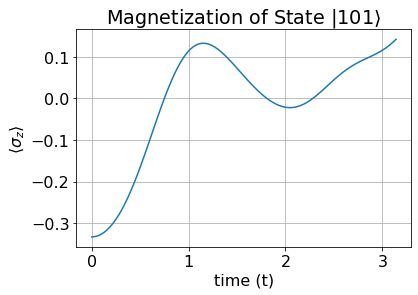

In [5]:
#Computational basis states for 3 qubits
states = [Zero^Zero^Zero, Zero^Zero^One, Zero^One^Zero, Zero^One^One, 
          One^Zero^Zero, One^Zero^One, One^One^Zero, One^One^One]

#Return the number of '1's in a given bit string
def bit_sum(n):
    sum = 0
    for bit in n:
        sum += int(bit)
    return sum

#Function to compute the magnetization from a given opflow state
def sigma_z(psi_t):
    state_probs = []
    for state in states:
        bit_string = list(state.primitive.keys())[0]
        bitsum = bit_sum(bit_string)
        state_probs.append((3.-2.*bitsum) * np.abs((~state @ psi_t).eval())**2)
    return sum(state_probs)/3
        
        
ts = np.linspace(0, np.pi, 100)

#Define your initial state
init_state = One^Zero^One

#Compute the magnetization at each time step
mags = [sigma_z(U_ising(float(t), J, g) @ init_state) for t in ts]



# Plot evolution of |110>
plt.plot(ts, mags)
plt.xlabel('time (t)')
plt.ylabel(r'$\langle\sigma_z\rangle$')
plt.title(r'Magnetization of State $|${}$\rangle$'.format(list(init_state.primitive.keys())[0]))
plt.grid()
plt.show()
    




## Trotterization <a id='trotterization'></a>
    
Now that we understand what about the Ising model we are interested in, let's take a look at what the time evolution operator $U(t)$ looks like as we "Trotterize" it.  If we assume a system of three sites and open boundary conditions, the Hamiltonian can be written as
$$
        H_{Ising} = J\sum_i(Z_iZ_{i+1} + gX_i) = JZ_0Z_1 + JZ_1Z_2 + JgX_0 + JgX_1 + JgX_2.
$$

We can then expand this out using the Trotter-Suzuki decomposition with $m$ slices
$$
       U(t) = \exp\left(-it\left(J\sum_i(Z_iZ_{i+1} + gX_i)\right)\right) \\
           \approx \left[\prod_i \exp\left(-iH_i t/m\right)\right]^m \\
           = \left[e^{-it/mJ Z_0Z_1} e^{-it/mJ Z_1Z_2} e^{-it/mJgX_0} e^{-it/mJgX_1} e^{-it/mJgX_2}\right]^m \\
           = \left[e^{-i\theta_1 Z_0Z_1} e^{-i\theta_1 Z_1Z_2} e^{-i\theta_2X_0} e^{-i\theta_2X_1} e^{-i\theta_2X_2}\right]^m
$$

and are left with 5 exponential operators of the form either $ZZ(\theta)$ or $X(\theta)$.  These operators have matrix representations of:

$$
    ZZ(\theta) = \begin{pmatrix} e^{-i\frac{\theta}{2}} & 0 & 0 & 0 \\
                                0 & e^{i\frac{\theta}{2}} & 0 & 0 \\ 
                                0 & 0 & e^{i\frac{\theta}{2}} & 0 \\ 
                                0 & 0 & 0 & e^{-i\frac{\theta}{2}}  \end{pmatrix} \\ 
                                \\ 
    X(\theta) = \begin{pmatrix} \cos\left(\frac{\theta}{2}\right) & i\sin\left(\frac{\theta}{2}\right) \\
                                i\sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right) \end{pmatrix}
$$



<h3 style="font-size: 20px">&#128211; Expand each of the operators of U(t) and show that they are equivalent to the rotation matrices above.


Consider only one of the exponentials: $e^{-i\theta Z_0Z_1}$
$$ e^{-i\theta_1 Z_0Z_1} = \cos(\theta)*I - i*\sin(\theta) Z_0Z_1 $$ (results from one of the problems in HW-1)
Writing out the matrices I and $Z_0Z_1$ we get:

$$ e^{-i\theta_1 Z_0Z_1} = \begin{pmatrix} \cos(\theta_1) & 0 & 0 & 0 \\
                                0 & \cos(\theta_1) & 0 & 0 \\ 
                                0 & 0 & \cos(\theta_1) & 0 \\ 
                                0 & 0 & 0 & \cos(\theta_1)  \end{pmatrix} \\ $$ - $$ - \begin{pmatrix} i*\sin(\theta_1) & 0 & 0 & 0 \\
                                0 & -i*\sin(\theta_1) & 0 & 0 \\ 
                                0 & 0 & -i*\sin(\theta_1) & 0 \\ 
                                0 & 0 & 0 & i*\sin(\theta_1)  \end{pmatrix} \\ $$ $\theta_1 = \theta/2$ $$ \begin{pmatrix} e^{-i\frac{\theta}{2}} & 0 & 0 & 0 \\
                                0 & e^{i\frac{\theta}{2}} & 0 & 0 \\ 
                                0 & 0 & e^{i\frac{\theta}{2}} & 0 \\ 
                                0 & 0 & 0 & e^{-i\frac{\theta}{2}}  \end{pmatrix}$$ 
                                
                                
Consider another exponential: $e^{-i\theta_2 X_1}$
Following the same logic from before: $$ e^{-i\theta_2 X_1} = \cos(\theta_2)*I - i*\sin(\theta_2) X_1 $$

Writing out the matrices, I and X we get:

$$ e^{-i\theta_2 X_1} = \begin{pmatrix} \cos(\theta_1) & 0   \\
                                0 & \cos(\theta_1)  \end{pmatrix} \\  $$  $$ -\begin{pmatrix} 0 & -i*\sin(\theta_2)  \\
                                -i*\sin(\theta_2) & 0  \end{pmatrix} \\ $$
$\theta_2 = \theta/2$

$$ e^{-i\theta_2 X_1} = \begin{pmatrix} \cos(\theta/2) & i\sin(\theta/2)   \\
                                i\sin(\theta/2) & \cos(\theta/2)  \end{pmatrix} \\ $$

## Qiskit Implementation <a id='qiskit'></a>

<h3 style="font-size: 20px">&#128211; Step A.  Build a circuit that will implement the operator $U(t)$ for a given target time and number of Trotter steps.

In [6]:
#from qiskit.circuit.library import RXGate, RZZGate
from qiskit import *


In [7]:
#### Your code goes here

#Conveniently enough, qiskit has both a ZZ(theta) and X(theta) gates by default. Check the docs on how to call them.
#Start by calculating the angle theta for a given time and number of steps. Then create function(s) to add on 

    
def Trotter_Suzuki(t,m): 
    '''Function for Trotter-Suzuki decomposition
    inputs: the amount of time to run it (t), number of Trotter steps (m)
    Return: the circuit after applying the RX and RZZ gates m times'''
    
    theta = 2*t/m #J=1 
    
    q = QuantumRegister(3,'q')
    c = ClassicalRegister(3,'c')

    circuit = QuantumCircuit(q,c) # initializing the circuit with 3 qubits and 3 classical bits.
    
    circuit.x(0) # applying X gates to 1st and 3rd to convert to |101>
    circuit.x(2)
    
    for step in range(1,m+1): # applying the U(t) function m times
        circuit.rx(theta,q[2])
        circuit.rx(theta,q[1])
        circuit.rx(theta,q[0])
        circuit.rzz(theta,q[0],q[1])
        circuit.rzz(theta,q[1],q[2])
    
    circuit.measure(q,c)
    
    return circuit
            
    


<h3 style="font-size: 20px">&#128211; Step B. Measure and plot the expectation of the state $|101\rangle$ as shown in section 3.1.  Plot this for several different numbers of Trotter steps to see how the trotterized $U(t)$ begins to converge to the true $U(t)$

### For 2 Trotter Steps:

In [8]:
#### Your code goes here

#Note in the example plot, the parameters J = g = 1.0

#Recall that the results are returned as a dict object with the bitstring as keys and the number of counts as values.
# A suggestion to run this quickly is to use the Aer simulator backend.  For extra points, plot the time evolution
#  using a real device

backend = Aer.get_backend('aer_simulator')
prob_101_state_TS2 =[] # creating an empty array that will store all the probabilities

for t in np.arange(0.0,3.0,0.1): # running each Trotter step for 3 seconds
    
    t_circ = Trotter_Suzuki(t,2)
    
    transpiled = transpile(t_circ, backend=backend)
    qobj = assemble(transpiled)
    
    job = backend.run(qobj,shots = 1024)
    
    results = job.result()
    counts = results.get_counts()
     
    for key in counts.keys(): # for every key in the dictionary 'counts'
        if key == '101': # if key is '101'
            values = counts[key]/1024. #find the probability of that state
            prob_101_state_TS2.append(values) # append that probability to the array
            
print(prob_101_state_TS2)

[1.0, 0.9716796875, 0.888671875, 0.7509765625, 0.62890625, 0.5205078125, 0.439453125, 0.349609375, 0.2841796875, 0.2509765625, 0.232421875, 0.1650390625, 0.12890625, 0.0732421875, 0.03125, 0.009765625, 0.0009765625, 0.0224609375, 0.05859375, 0.14453125, 0.2255859375, 0.3115234375, 0.39453125, 0.5048828125, 0.58984375, 0.6923828125, 0.732421875, 0.8291015625, 0.9052734375, 0.9482421875]


### For 3 Trotter Steps:

In [9]:
prob_101_state_TS3 =[] 
for t in np.arange(0.0,3.0,0.1):
    
    t_circ = Trotter_Suzuki(t,3)
    
    transpiled = transpile(t_circ, backend=backend)
    qobj = assemble(transpiled)
    
    job = backend.run(qobj,shots = 1024)
    
    results = job.result()
    counts = results.get_counts()
     
    for key in counts.keys():
        if key == '101':
            values = counts[key]/1024.
            prob_101_state_TS3.append(values)
            
print(prob_101_state_TS3)

[1.0, 0.966796875, 0.8896484375, 0.7822265625, 0.6240234375, 0.5263671875, 0.427734375, 0.33984375, 0.2841796875, 0.2451171875, 0.2109375, 0.1875, 0.1337890625, 0.107421875, 0.0927734375, 0.1298828125, 0.1630859375, 0.2236328125, 0.3037109375, 0.38671875, 0.462890625, 0.478515625, 0.5078125, 0.5244140625, 0.4931640625, 0.4208984375, 0.353515625, 0.310546875, 0.25, 0.1796875]


### For 4 Trotter Steps:

In [10]:
prob_101_state_TS4 =[] 
for t in np.arange(0.0,3.0,0.1):
    
    t_circ = Trotter_Suzuki(t,4)
    
    transpiled = transpile(t_circ, backend=backend)
    qobj = assemble(transpiled)
    
    job = backend.run(qobj,shots = 1024)
    
    results = job.result()
    counts = results.get_counts()
     
    for key in counts.keys():
        if key == '101':
            values = counts[key]/1024.
            prob_101_state_TS4.append(values)
            
print(prob_101_state_TS4)

[1.0, 0.9765625, 0.89453125, 0.7666015625, 0.65234375, 0.5517578125, 0.4482421875, 0.3388671875, 0.330078125, 0.265625, 0.228515625, 0.1904296875, 0.1611328125, 0.1162109375, 0.1357421875, 0.1650390625, 0.2197265625, 0.3037109375, 0.3671875, 0.4814453125, 0.521484375, 0.546875, 0.505859375, 0.4892578125, 0.4150390625, 0.37109375, 0.3193359375, 0.2578125, 0.2548828125, 0.2216796875]


## Plot for the probability of state '101'

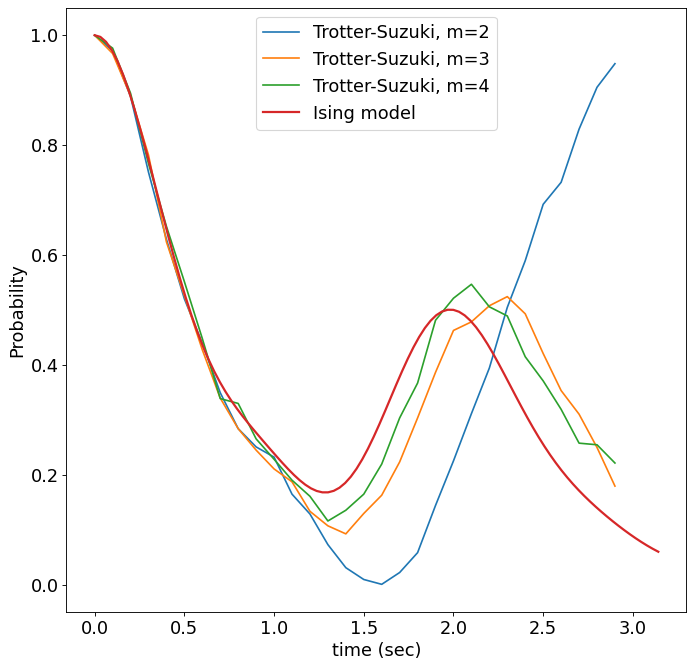

In [11]:
times = np.arange(0., 3., 0.1)

from matplotlib.pyplot import figure

figure(figsize=(10, 10), dpi=80)


plt.plot(times, prob_101_state_TS2,label='Trotter-Suzuki, m=2')
plt.plot(times, prob_101_state_TS3, label='Trotter-Suzuki, m=3')
plt.plot(times, prob_101_state_TS4, label='Trotter-Suzuki, m=4')
plt.plot(ts, probs_101,linewidth = 2.0,label='Ising model')
plt.xlabel('time (sec)')
plt.ylabel('Probability')
plt.legend(loc='best')
plt.show()

<h3 style="font-size: 17px">&#128211; Step C. Write a function to process the circuit results and calculate $\langle\sigma_z\rangle$.  Plot this against time as shown further above

In [12]:
#### Your code goes here

#A helpful starting point here is to remember that the magnetization can be measured by examining each bitstring 
# from the results.

def digit_sum(n):
    '''A function to calculate the number of ones in a given bit string
    Input: the bit string (n)
    Returns: the sum of the digits in the bit string'''
    
    sum_of_digits = 0 # set initial sum to 0
    for num in n:
        sum_of_digits += int(num) # add 1 or 0 bit to the sum
    
    return sum_of_digits # return the sum



### For 2 Trotter Steps:

In [35]:
backend = Aer.get_backend('aer_simulator')

mags_TS2 = [] # creating an empty array that will store all the magnetizations

for t in np.arange(0.0,3.0,0.1):
    
    t_circ = Trotter_Suzuki(t,2)
    
    transpiled = transpile(t_circ, backend=backend)
    qobj = assemble(transpiled)
    
    job = backend.run(qobj,shots = 1024)
    
    results = job.result()
    counts = results.get_counts() # dict object
    
    
    mag_value = 0
    for key in counts.keys(): # for all keys in the dictionary, 'counts'
        probability = counts[key]/1024. # calculate the probability of each state.
        mag_value += (3 - 2*digit_sum(key))*probability # implementation of the <sigma_z> formula given above. 
    #print(counts.keys(),mag_value/3.)
            
    mags_TS2.append(mag_value/3.) # dividing by the number of qubits (3).
    
print(mags_TS2)
    
    

[-0.3333333333333333, -0.3287760416666667, -0.3098958333333333, -0.271484375, -0.220703125, -0.17578125, -0.10807291666666667, -0.017578125, 0.057291666666666664, 0.07356770833333333, 0.14908854166666666, 0.15559895833333334, 0.162109375, 0.140625, 0.09049479166666667, 0.01953125, -0.03515625, -0.07942708333333333, -0.15494791666666666, -0.220703125, -0.3053385416666667, -0.37890625, -0.3880208333333333, -0.4283854166666667, -0.44921875, -0.431640625, -0.4368489583333333, -0.4166666666666667, -0.3919270833333333, -0.37109375]


### For 3 Trotter Steps:

In [14]:
mags_TS3 = []

for t in np.arange(0.0,3.0,0.1):
    
    t_circ = Trotter_Suzuki(t,3)
    
    transpiled = transpile(t_circ, backend=backend)
    qobj = assemble(transpiled)
    
    job = backend.run(qobj,shots = 1024)
    
    results = job.result()
    counts = results.get_counts()
    
    
    mag_value = 0
    for key in counts.keys():
        probability = counts[key]/1024.
        mag_value += (3 - 2*digit_sum(key))*probability
            
    mags_TS3.append(mag_value/3.)
    
print(mags_TS3)

[-0.3333333333333333, -0.3294270833333333, -0.314453125, -0.2701822916666667, -0.22265625, -0.15885416666666666, -0.078125, 0.0006510416666666666, 0.018880208333333332, 0.08333333333333333, 0.13020833333333334, 0.15494791666666666, 0.14583333333333334, 0.126953125, 0.09440104166666667, 0.06901041666666667, 0.055338541666666664, 0.018229166666666668, -0.024739583333333332, -0.020182291666666668, -0.041015625, -0.046223958333333336, -0.020182291666666668, 0.005859375, 0.018229166666666668, 0.03515625, 0.0703125, 0.091796875, 0.15364583333333334, 0.17122395833333334]


### For 4 Trotter Steps:

In [15]:
mags_TS4 = []

for t in np.arange(0.0,3.0,0.1):
    
    t_circ = Trotter_Suzuki(t,4)
    
    transpiled = transpile(t_circ, backend=backend)
    qobj = assemble(transpiled)
    
    job = backend.run(qobj,shots = 1024)
    
    results = job.result()
    counts = results.get_counts()
    
    
    mag_value = 0
    for key in counts.keys():
        probability = counts[key]/1024.
        mag_value += (3 - 2*digit_sum(key))*probability
            
    mags_TS4.append(mag_value/3.)
    
print(mags_TS4)

[-0.3333333333333333, -0.3268229166666667, -0.3125, -0.2740885416666667, -0.22591145833333334, -0.17708333333333334, -0.10091145833333333, -0.007161458333333333, 0.061848958333333336, 0.103515625, 0.125, 0.14322916666666666, 0.140625, 0.13411458333333334, 0.09049479166666667, 0.06705729166666667, 0.049479166666666664, 0.043619791666666664, -0.033203125, -0.014322916666666666, -0.014973958333333334, -0.01953125, -0.0390625, -0.018229166666666668, 0.012369791666666666, -0.01171875, 0.043619791666666664, 0.060546875, 0.052734375, 0.041666666666666664]


## Plot for Magnetization at different Trotter Steps:

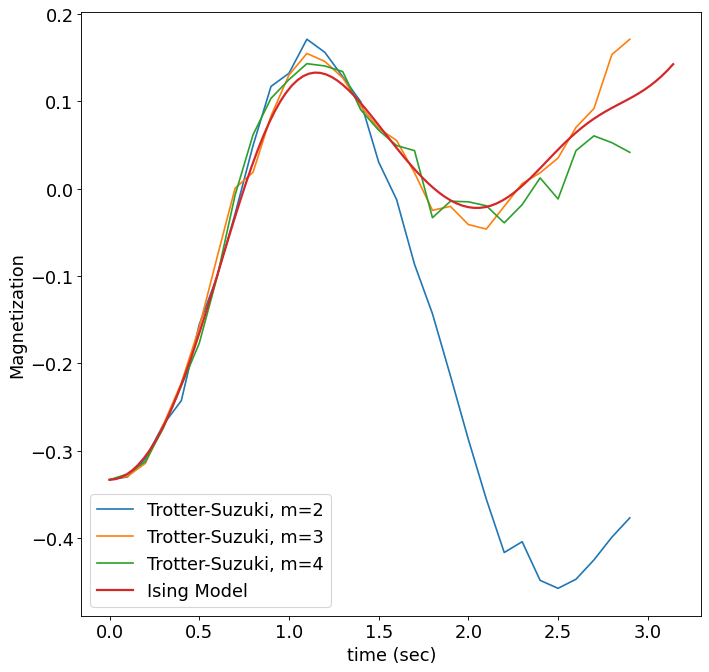

In [16]:
figure(figsize=(10, 10), dpi=80)


plt.plot(times, mags_TS2,label='Trotter-Suzuki, m=2')
plt.plot(times, mags_TS3,label='Trotter-Suzuki, m=3')
plt.plot(times, mags_TS4,label='Trotter-Suzuki, m=4')
plt.plot(ts, mags,linewidth = 2.0, label = 'Ising Model')
plt.xlabel('time (sec)')
plt.ylabel('Magnetization')
plt.legend(loc='best')
plt.show()

<h3 style="font-size: 17px">&#128211; Step D. Run these circuits on your favorite backend and plot against the simulated data.

In [17]:
#### Your code goes here
IBMQ.load_account()

provider = IBMQ.get_provider(hub = 'ibm-q-education', group='ohio-uni-1',project='spring2022')

backend_IBM = provider.get_backend('ibmq_lima')

In [18]:
init_layout = [0,1,2]

### Running IBMQ Lima with 2 Trotter steps:

In [19]:
# I am basically doing the same thing as I did with the aer_simulator. 
# The only thing that has changed is the backend

prob_101_state_IBM_TS2 =[] 

for t in np.arange(0.0,3.0,0.1):
    
    t_circ = Trotter_Suzuki(t,2)
    
    transpiled = transpile(t_circ, backend=backend_IBM, initial_layout=init_layout)
    qobj = assemble(transpiled)
    
    job = backend.run(qobj,shots = 1024)
    
    results = job.result()
    counts = results.get_counts()
     
    for key in counts.keys():
        if key == '101':
            values = counts[key]/1024.
            prob_101_state_IBM_TS2.append(values)
            
print(prob_101_state_IBM_TS2)

[1.0, 0.974609375, 0.8759765625, 0.7783203125, 0.6494140625, 0.5068359375, 0.396484375, 0.322265625, 0.2880859375, 0.2666015625, 0.201171875, 0.15625, 0.125, 0.0673828125, 0.0439453125, 0.0048828125, 0.001953125, 0.021484375, 0.0693359375, 0.12109375, 0.2177734375, 0.3037109375, 0.4140625, 0.5244140625, 0.6015625, 0.6796875, 0.7763671875, 0.8359375, 0.908203125, 0.9443359375]


### Running IBMQ Lima with 3 Trotter steps:

In [22]:
prob_101_state_IBM_TS3 =[] 

for t in np.arange(0.0,3.0,0.1):
    
    t_circ = Trotter_Suzuki(t,3)
    
    transpiled = transpile(t_circ, backend=backend_IBM, initial_layout=init_layout)
    qobj = assemble(transpiled)
    
    job = backend.run(qobj,shots = 1024)
    
    results = job.result()
    counts = results.get_counts()
     
    for key in counts.keys():
        if key == '101':
            values = counts[key]/1024.
            prob_101_state_IBM_TS3.append(values)
            
print(prob_101_state_IBM_TS3)

[1.0, 0.98046875, 0.8798828125, 0.775390625, 0.642578125, 0.5400390625, 0.40625, 0.36328125, 0.2802734375, 0.244140625, 0.2412109375, 0.1845703125, 0.14453125, 0.1064453125, 0.08203125, 0.1279296875, 0.1630859375, 0.224609375, 0.3076171875, 0.36328125, 0.4326171875, 0.49609375, 0.509765625, 0.5380859375, 0.5048828125, 0.43359375, 0.37109375, 0.2763671875, 0.240234375, 0.162109375]


### Running IBMQ Lima with 4 Trotter steps:

In [27]:
prob_101_state_IBM_TS4 =[] 

for t in np.arange(0.0,3.0,0.1):
    
    t_circ = Trotter_Suzuki(t,4)
    
    transpiled = transpile(t_circ, backend=backend_IBM, initial_layout=init_layout)
    qobj = assemble(transpiled)
    
    job = backend.run(qobj,shots = 1024)
    
    results = job.result()
    counts = results.get_counts()
     
    for key in counts.keys():
        if key == '101':
            values = counts[key]/1024.
            prob_101_state_IBM_TS4.append(values)
            
print(prob_101_state_IBM_TS4)

[1.0, 0.9638671875, 0.8857421875, 0.791015625, 0.662109375, 0.5244140625, 0.4306640625, 0.3623046875, 0.302734375, 0.27734375, 0.2158203125, 0.1884765625, 0.14453125, 0.1044921875, 0.125, 0.177734375, 0.232421875, 0.328125, 0.38671875, 0.46484375, 0.5048828125, 0.5283203125, 0.48828125, 0.474609375, 0.4404296875, 0.3642578125, 0.2998046875, 0.2646484375, 0.232421875, 0.2392578125]


## Plots comparing simulator and IBMQ results:

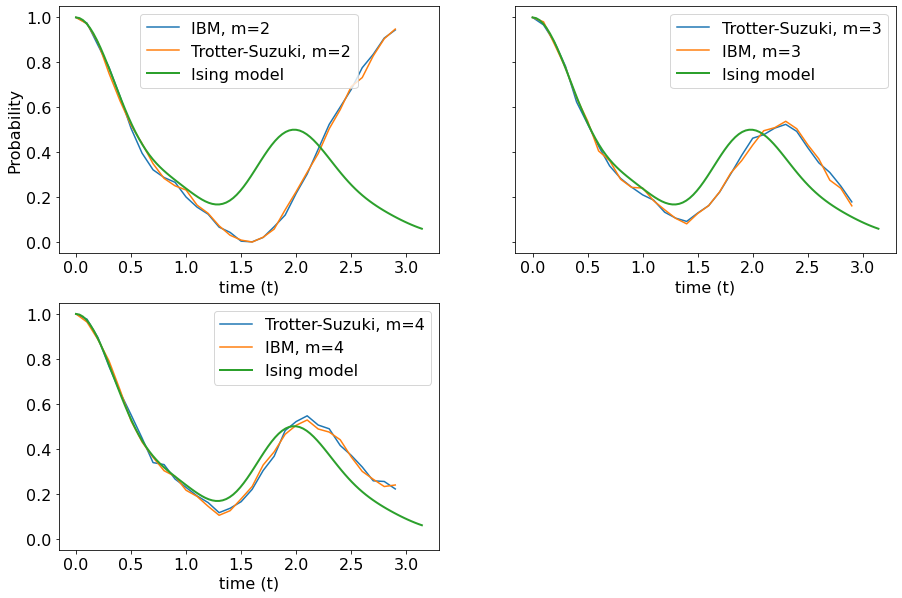

In [29]:
fig, [(ax1,ax2),(ax3,ax4)] = plt.subplots(2,2,figsize=(15,10),sharey=True)


ax1.plot(times, prob_101_state_IBM_TS2,label='IBM, m=2')
ax1.plot(times, prob_101_state_TS2, label='Trotter-Suzuki, m=2')
ax1.plot(ts, probs_101,linewidth=2.0,label='Ising model')

ax2.plot(times, prob_101_state_TS3, label='Trotter-Suzuki, m=3')
ax2.plot(times, prob_101_state_IBM_TS3, label='IBM, m=3')
ax2.plot(ts, probs_101,linewidth=2.0,label='Ising model')

ax3.plot(times, prob_101_state_TS4, label='Trotter-Suzuki, m=4')
ax3.plot(times, prob_101_state_IBM_TS4, label='IBM, m=4')
ax3.plot(ts, probs_101,linewidth=2.0,label='Ising model')

fig.delaxes(ax4)


ax1.set_xlabel('time (t)')
ax1.set_ylabel('Probability')

ax2.set_xlabel('time (t)')
ax3.set_xlabel('time (t)')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')
plt.show()

### Magnetization calculation for 2 Trotter Steps at IBMQ Lima

In [31]:
mags_TS2_IBM = []

for t in np.arange(0.0,3.0,0.1):
    
    t_circ = Trotter_Suzuki(t,2)
    
    transpiled = transpile(t_circ, backend=backend_IBM, initial_layout=init_layout)
    qobj = assemble(transpiled)
    
    job = backend.run(qobj,shots = 1024)
    
    results = job.result()
    counts = results.get_counts()
    
    
    mag_value = 0
    for key in counts.keys():
        probability = counts[key]/1024.
        mag_value += (3 - 2*digit_sum(key))*probability
    #print(counts.keys(),mag_value/3.)
            
    mags_TS2_IBM.append(mag_value/3.)
    
print(mags_TS2_IBM)
    

[-0.3333333333333333, -0.328125, -0.3020833333333333, -0.2747395833333333, -0.21549479166666666, -0.17513020833333334, -0.10026041666666667, -0.037109375, 0.025390625, 0.076171875, 0.15104166666666666, 0.16145833333333334, 0.1640625, 0.15234375, 0.11002604166666667, 0.025390625, -0.051432291666666664, -0.10481770833333333, -0.18033854166666666, -0.2584635416666667, -0.263671875, -0.3502604166666667, -0.38671875, -0.4290364583333333, -0.4518229166666667, -0.4622395833333333, -0.4401041666666667, -0.42578125, -0.384765625, -0.3548177083333333]


### Magnetization calculation for 3 Trotter Steps at IBMQ Lima

In [32]:
mags_TS3_IBM = []

for t in np.arange(0.0,3.0,0.1):
    
    t_circ = Trotter_Suzuki(t,3)
    
    transpiled = transpile(t_circ, backend=backend_IBM, initial_layout=init_layout)
    qobj = assemble(transpiled)
    
    job = backend.run(qobj,shots = 1024)
    
    results = job.result()
    counts = results.get_counts()
    
    
    mag_value = 0
    for key in counts.keys():
        probability = counts[key]/1024.
        mag_value += (3 - 2*digit_sum(key))*probability
    #print(counts.keys(),mag_value/3.)
            
    mags_TS3_IBM.append(mag_value/3.)
    
print(mags_TS3_IBM)
    

[-0.3333333333333333, -0.3294270833333333, -0.3046875, -0.2649739583333333, -0.2513020833333333, -0.14713541666666666, -0.10611979166666667, -0.034505208333333336, 0.03515625, 0.08138020833333333, 0.140625, 0.1484375, 0.15169270833333334, 0.123046875, 0.11263020833333333, 0.091796875, 0.040364583333333336, 0.00390625, -0.0013020833333333333, -0.011067708333333334, -0.048177083333333336, -0.055338541666666664, -0.021484375, -0.017578125, 0.0006510416666666666, 0.037109375, 0.0625, 0.10091145833333333, 0.12174479166666667, 0.16861979166666666]


### Magnetization calculation for 4 Trotter Steps at IBMQ Lima

In [33]:
mags_TS4_IBM = []

for t in np.arange(0.0,3.0,0.1):
    
    t_circ = Trotter_Suzuki(t,4)
    
    transpiled = transpile(t_circ, backend=backend_IBM, initial_layout=init_layout)
    qobj = assemble(transpiled)
    
    job = backend.run(qobj,shots = 1024)
    
    results = job.result()
    counts = results.get_counts()
    
    
    mag_value = 0
    for key in counts.keys():
        probability = counts[key]/1024.
        mag_value += (3 - 2*digit_sum(key))*probability
    #print(counts.keys(),mag_value/3.)
            
    mags_TS4_IBM.append(mag_value/3.)
    
print(mags_TS4_IBM)
    

[-0.3333333333333333, -0.3307291666666667, -0.3092447916666667, -0.265625, -0.22786458333333334, -0.14388020833333334, -0.09114583333333333, -0.044921875, 0.042317708333333336, 0.115234375, 0.13736979166666666, 0.12955729166666666, 0.1171875, 0.103515625, 0.09375, 0.09440104166666667, 0.059895833333333336, 0.03515625, -0.022786458333333332, -0.0078125, -0.029947916666666668, -0.031901041666666664, -0.018880208333333332, -0.022786458333333332, 0.00390625, 0.0006510416666666666, 0.039713541666666664, 0.048828125, 0.044270833333333336, 0.033854166666666664]


## Plots comparing simulator and IBMQ results:

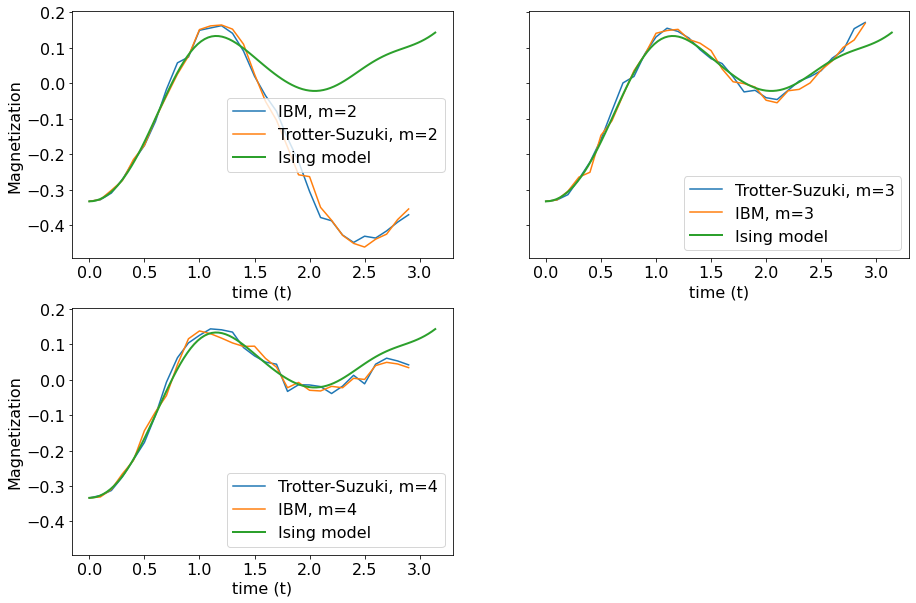

In [37]:
fig, [(ax1,ax2),(ax3,ax4)] = plt.subplots(2,2,figsize=(15,10),sharey=True)


ax1.plot(times, mags_TS2,label='IBM, m=2')
ax1.plot(times, mags_TS2_IBM, label='Trotter-Suzuki, m=2')
ax1.plot(ts, mags,linewidth=2.0,label='Ising model')

ax2.plot(times, mags_TS3, label='Trotter-Suzuki, m=3')
ax2.plot(times, mags_TS3_IBM, label='IBM, m=3')
ax2.plot(ts, mags,linewidth=2.0,label='Ising model')

ax3.plot(times, mags_TS4, label='Trotter-Suzuki, m=4')
ax3.plot(times, mags_TS4_IBM, label='IBM, m=4')
ax3.plot(ts, mags,linewidth=2.0,label='Ising model')

fig.delaxes(ax4)


ax1.set_xlabel('time (t)')
ax1.set_ylabel('Magnetization')

ax2.set_xlabel('time (t)')
ax3.set_xlabel('time (t)')
ax3.set_ylabel('Magnetization')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')
plt.show()